#Perspective Correction

**Uploading Images on google colab**

In [4]:
from google.colab import files

uploaded = files.upload()

Saving IMG_20190726_112717.jpg to IMG_20190726_112717.jpg
Saving IMG_20190726_112742.jpg to IMG_20190726_112742.jpg


# S**egmentation of image to remove background Noise**

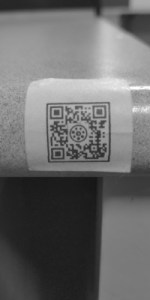

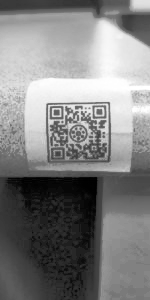

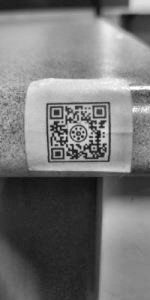

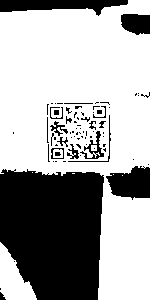

In [165]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

img = cv2.imread("IMG_20190726_112742.jpg",0)
cv2_imshow(img)
equ = cv2.equalizeHist(img)
#stacking images side-by-side
cv2_imshow(equ)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
cv2_imshow(cl1)

ret,thresh1 = cv2.threshold(cl1,80,255,cv2.THRESH_BINARY)
cv2_imshow(thresh1)

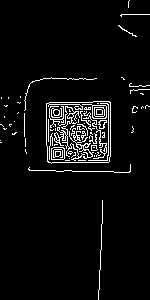

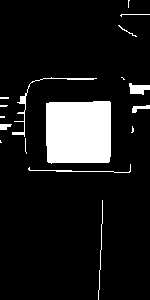

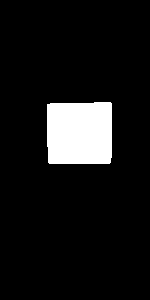

In [166]:
edges_image = cv2.Canny(cl1, 200, 250)
cv2_imshow(edges_image)
# Close gaps between edges (double page clouse => rectangle kernel)
edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))
cv2_imshow(edges_image)

kernel = np.ones((10,10),np.uint8)
erosion = cv2.erode(edges_image,kernel,iterations = 1)
dilation = cv2.dilate(erosion,kernel,iterations = 1)
ret,dilation = cv2.threshold(dilation,80,255,cv2.THRESH_BINARY)
cv2_imshow(dilation)

im2, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# This function is used to find the corners of the object and the dimensions of the object



In [0]:
def transform(pos):
	pts=[]
	n=len(pos)
	for i in range(n):
		pts.append(list(pos[i][0]))
		
	sums={}
	diffs={}
	
	for i in pts:
		x=i[0]
		y=i[1]
		sum=x+y
		diff=y-x
		sums[sum]=i
		diffs[diff]=i
	sums=sorted(sums.items())
	diffs=sorted(diffs.items())
	n=len(sums)
	rect=[sums[0][1],diffs[0][1],diffs[n-1][1],sums[n-1][1]]
	#	   top-left   top-right   bottom-left   bottom-right
	
	h1=np.sqrt((rect[0][0]-rect[2][0])**2 + (rect[0][1]-rect[2][1])**2)		#height of left side
	h2=np.sqrt((rect[1][0]-rect[3][0])**2 + (rect[1][1]-rect[3][1])**2)		#height of right side
	h=max(h1,h2)
	
	w1=np.sqrt((rect[0][0]-rect[1][0])**2 + (rect[0][1]-rect[1][1])**2)		#width of upper side
	w2=np.sqrt((rect[2][0]-rect[3][0])**2 + (rect[2][1]-rect[3][1])**2)		#width of lower side
	w=max(w1,w2)
	
	return int(w),int(h),rect

In [0]:
_,contours,_=cv2.findContours(dilation.copy(),1,1)
#cv2.drawContours(img,contours,-1,[0,255,0],2)
max_area=0
pos=0
for i in contours:
    area=cv2.contourArea(i)
    if area>max_area:
        max_area=area
        pos=i
peri=cv2.arcLength(pos,True)
approx=cv2.approxPolyDP(pos,0.02*peri,True)
w,h,arr=transform(approx)

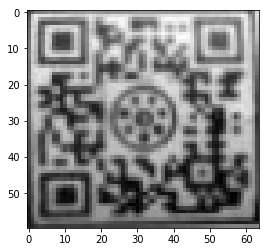

In [169]:
pts2=np.float32([[0,0],[w,0],[0,h],[w,h]])
pts1=np.float32(arr)
M=cv2.getPerspectiveTransform(pts1,pts2)
dst=cv2.warpPerspective(img,M,(w,h))
#image=cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)
#image=cv2.adaptiveThreshold(image,255,1,0,11,2)
image = cv2.resize(dst,(w,h),interpolation = cv2.INTER_AREA)
plt.imshow(image,'gray')